# Notebook to train a DNN for trump selection

### Libraries

We use the keras library for building, training and evaluating the network. A tutorial for keras can be found on (https://keras.io/) or https://www.tensorflow.org/guide/keras. There are different implementations of keras, here I will use the one build on tensorflow.


In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [10]:

path_to_data = Path('data')
# Import only a fraction of data for efficient testing
data = pd.read_csv(path_to_data / '2018_10_18_trump.csv', header=None)
cards = [
# Diamonds
'DA','DK','DQ','DJ','D10','D9','D8','D7','D6',
# Hearts
'HA','HK','HQ','HJ','H10','H9','H8','H7','H6',
# Spades
'SA','SK','SQ','SJ','S10','S9','S8','S7','S6',
# Clubs
'CA','CK','CQ','CJ','C10','C9','C8','C7','C6'
]

# Forehand (yes = 1, no = 0)
forehand = ['FH']

user  = ['user']
trump = ['trump']

data.columns = cards + forehand + user + trump
data.drop('user', axis='columns', inplace=True)

data.trump = data.trump.astype('category')
data[cards + forehand] = data[cards + forehand].astype(bool)
#data.trump.cat.rename_categories({6: 10}, inplace=True)

data.head()

data.trump.value_counts()
trump = data.pop('trump')
print(trump.unique())
y_train = tf.keras.utils.to_categorical(trump)

    
    # Exercise: Add other features here such as the combination of Ace-King-Queen (Dreiblatt).

print(y_train.shape)

[6, 5, 4, 1, 0, 2, 3]
Categories (7, int64): [6, 5, 4, 1, 0, 2, 3]
(359825, 7)


In [3]:
data.head()

,DA,DK,DQ,DJ,D10,D9,D8,D7,D6,HA,...,CA,CK,CQ,CJ,C10,C9,C8,C7,C6,FH
0,False,False,False,True,True,False,True,True,False,False,...,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,True,False,False
2,True,False,False,True,False,False,False,False,False,False,...,False,False,True,False,False,False,False,True,True,False
3,False,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,True,False,False,False,False
4,False,True,False,False,False,False,False,False,True,True,...,False,False,False,True,False,False,False,False,False,True


In [6]:
model = keras.Sequential()
model.add(keras.layers.Dense(37, activation='relu', input_shape=[37]))
model.add(keras.layers.Dense(37, activation='relu'))
model.add(keras.layers.Dense(37, activation='relu'))
model.add(keras.layers.Dense(37, activation='relu'))
model.add(keras.layers.Dense(37, activation='relu'))
model.add(keras.layers.Dense(7, activation='softmax'))



model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [7]:
print(data.shape)
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(data.values, y_train, validation_split=0.25, epochs=20, batch_size=1000,
              callbacks =[early_stop])

(359825, 37)
Epoch 1/20
270/270 [==============================] - 3s 7ms/step - loss: 1.2645 - accuracy: 0.5175 - val_loss: 0.8989 - val_accuracy: 0.6329
Epoch 2/20
270/270 [==============================] - 2s 6ms/step - loss: 0.8816 - accuracy: 0.6327 - val_loss: 0.8674 - val_accuracy: 0.6409
Epoch 3/20
270/270 [==============================] - 2s 6ms/step - loss: 0.8525 - accuracy: 0.6388 - val_loss: 0.8431 - val_accuracy: 0.6367
Epoch 4/20
270/270 [==============================] - 2s 6ms/step - loss: 0.8308 - accuracy: 0.6438 - val_loss: 0.8253 - val_accuracy: 0.6361
Epoch 5/20
270/270 [==============================] - 2s 6ms/step - loss: 0.8192 - accuracy: 0.6474 - val_loss: 0.8143 - val_accuracy: 0.6530
Epoch 6/20
270/270 [==============================] - 2s 6ms/step - loss: 0.8114 - accuracy: 0.6500 - val_loss: 0.8101 - val_accuracy: 0.6518
Epoch 7/20
270/270 [==============================] - 2s 7ms/step - loss: 0.8057 - accuracy: 0.6524 - val_loss: 0.8043 - val_accuracy: 

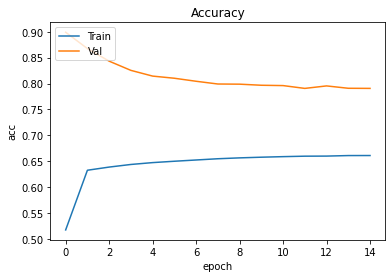

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend(['Train', 'Val'], loc='upper left')

In [9]:
model.save('models/v1')


INFO:tensorflow:Assets written to: models/v1\assets
